In [206]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
pd.options.display.max_rows = 4000
pd.options.display.max_columns
pd.options.display.float_format = '{:.3f}'.format 
np.set_printoptions(suppress=True, precision=5)

import warnings
warnings.filterwarnings("ignore")

In [278]:
#import
df = pd.read_csv(r'E:\learn st new\Credit score\loan_LG_model.csv', low_memory= False)
df.head()

,term,int_rate,grade,home_ownership,annual_inc,verification_status,purpose,dti,total_rec_late_fee,loan_issue_m,loan_status
0,36,"(9.548, 11.612]",B,RENT,"(1895, 30000]",Verified,credit_card,"(23.994, 27.993]","(-0.1, 35.868]","(30.0, 80.0]",0
1,60,"(13.676, 15.74]",C,RENT,"(1895, 30000]",Source Verified,car,"(-0.04, 3.999]","(-0.1, 35.868]","(30.0, 80.0]",1
2,36,"(15.74, 17.804]",C,RENT,"(1895, 30000]",Not Verified,small_business,"(7.998, 11.997]","(-0.1, 35.868]","(30.0, 80.0]",0
3,36,"(11.612, 13.676]",C,RENT,"(30000, 100000]",Source Verified,other,"(19.995, 23.994]","(-0.1, 35.868]","(30.0, 80.0]",0
4,36,"(7.484, 9.548]",A,RENT,"(30000, 100000]",Source Verified,wedding,"(7.998, 11.997]","(-0.1, 35.868]","(30.0, 80.0]",0


In [322]:
import ast

import pandas as pd


def interval_type(s):
    """Parse interval string to Interval"""
    
    table = str.maketrans({'[': '(', ']': ')'})
    left_closed = s.startswith('[')
    right_closed = s.endswith(']')

    left, right = ast.literal_eval(s.translate(table))

    t = 'neither'
    if left_closed and right_closed:
        t = 'both'
    elif left_closed:
        t = 'left'
    elif right_closed:
        t = 'right'

    return pd.Interval(left, right, closed=t)


In [143]:
def woe_discrete(df,independent_variable,dependent_variable):
    df = pd.concat([df[independent_variable],dependent_variable],axis=1)
    df = pd.concat([df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].count(),
                    df.groupby(df.columns.values[0],as_index=False)[df.columns.values[1]].mean()],axis=1)
    df = df.iloc[:,[0,1,3]]
    
    df.columns = [df.columns.values[0],'n_obs','prop_bad']
    df['no_bad'] = df['prop_bad'] * df['n_obs']
    df['no_good'] = (1- df['prop_bad']) * df['n_obs']
    df['Final_good'] = df['no_good']/df['no_good'].sum()
    df['Final_bad'] = df['no_bad']/df['no_bad'].sum()
    df['WOE'] = np.log(df['Final_good']/df['Final_bad'])

    
    df = df.sort_values(['WOE'])
    df = df.reset_index(drop=True)
    df['diff_WoE'] = df['WOE'].diff().abs()
    df['IV'] = (df['Final_good']-df['Final_bad']) * df['WOE']
    df['IV_total'] = df['IV'].sum()
    # print('===================== Information value of ' +independent_variable+' is '+ str(round(df['IV'].sum(),3))+' ===================')
    return df

In [208]:
input =df.drop(columns = 'loan_status')
output = df['loan_status']

In [209]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    cols = data.columns
    
    #Run WoE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        if show_woe == True:
            print(d)
            
    return newDF, woeDF

iv, woe = iv_woe(df, target='loan_status', bins=10)

Information value of term is 0.162529
Information value of int_rate is 0.408432
Information value of grade is 0.395871
Information value of home_ownership is 0.013465
Information value of annual_inc is 0.027706
Information value of verification_status is 0.043537
Information value of purpose is 0.025231
Information value of dti is 0.09645
Information value of total_rec_late_fee is 0.047785
Information value of loan_issue_m is 0.062559


In [323]:
woe = woe[['Variable', 'Cutoff','WoE']]

In [212]:
woe = woe.reset_index()

In [213]:
input['term'] = input['term'].replace(36, -0.243)
input['term'] = input['term'].replace(60, 0.679)

input['int_rate'] = input['int_rate'].replace('(11.612, 13.676]', 0.228)
input['int_rate'] = input['int_rate'].replace('(13.676, 15.74]', 0.102)
input['int_rate'] = input['int_rate'].replace('(15.74, 17.804]', 0.398)
input['int_rate'] = input['int_rate'].replace('(17.804, 19.868]',0.603)
input['int_rate'] = input['int_rate'].replace('(19.868, 21.932]', 0.830)
input['int_rate'] = input['int_rate'].replace('(21.932, 23.996]', 1.039)
input['int_rate'] = input['int_rate'].replace('(23.996, 26.06]', 1.223)
input['int_rate'] = input['int_rate'].replace('(5.399, 7.484]', -1.680)
input['int_rate'] = input['int_rate'].replace('(7.484, 9.548]', -1.009)
input['int_rate'] = input['int_rate'].replace('(9.548, 11.612]', -0.586)

input['grade'] = input['grade'].replace('A',-1.241)
input['grade'] = input['grade'].replace('B',-0.440)
input['grade'] = input['grade'].replace('C',0.132)
input['grade'] = input['grade'].replace('D',0.490)
input['grade'] = input['grade'].replace('E',0.845)
input['grade'] = input['grade'].replace('F',1.055)
input['grade'] = input['grade'].replace('G',1.173)

input['home_ownership'] = input['home_ownership'].replace('MORTGAGE', -0.121)
input['home_ownership'] = input['home_ownership'].replace('OWN', 0.066)
input['home_ownership'] = input['home_ownership'].replace('RENT', 0.118)

input['annual_inc'] = input['annual_inc'].replace('(100000, 300000]', -0.357)
input['annual_inc'] = input['annual_inc'].replace('(1895, 30000]', 0.318)
input['annual_inc'] = input['annual_inc'].replace('(30000, 100000]', 0.030)
input['annual_inc'] = input['annual_inc'].replace('(300000, 7500000]', -0.459)

input['verification_status'] = input['verification_status'].replace('Not Verified', -0.305)
input['verification_status'] = input['verification_status'].replace('Source Verified', 0.122)
input['verification_status'] = input['verification_status'].replace('Verified', 0.158)

input['purpose'] = input['purpose'].replace('car',-0.557)
input['purpose'] = input['purpose'].replace('credit_card',	-0.152)
input['purpose'] = input['purpose'].replace('debt_consolidation',	0.062)
input['purpose'] = input['purpose'].replace('educational',	-0.054)
input['purpose'] = input['purpose'].replace('home_improvement'	,-0.164)
input['purpose'] = input['purpose'].replace('house',	-0.063)
input['purpose'] = input['purpose'].replace('major_purchase',	-0.384)
input['purpose'] = input['purpose'].replace('medical',	0.052)
input['purpose'] = input['purpose'].replace('moving',	0.144)
input['purpose'] = input['purpose'].replace('renewable_energy',	-0.069)
input['purpose'] = input['purpose'].replace('small_business',	0.526)
input['purpose'] = input['purpose'].replace('vacation',	-0.071)
input['purpose'] = input['purpose'].replace('wedding',	-0.567)
input['purpose'] = input['purpose'].replace('other'	,0.135)

input['dti'] = input['dti'].replace('(-0.04, 3.999]',	-0.512)
input['dti'] = input['dti'].replace('(11.997, 15.996]',	-0.151)
input['dti'] = input['dti'].replace('(15.996, 19.995]',	0.023)
input['dti'] = input['dti'].replace('(19.995, 23.994]',	0.171)
input['dti'] = input['dti'].replace('(23.994, 27.993]',	0.367)
input['dti'] = input['dti'].replace('(27.993, 31.992]',	0.535)
input['dti'] = input['dti'].replace('(3.999, 7.998]',	-0.428)
input['dti'] = input['dti'].replace('(31.992, 35.991]',	0.657)
input['dti'] = input['dti'].replace('(35.991, 39.99]',	1.360)
input['dti'] = input['dti'].replace('(35.991, 39.99]',	1.360)
input['dti'] = input['dti'].replace('(7.998, 11.997]',	-0.275)

input['total_rec_late_fee'] =input['total_rec_late_fee'].replace('(-0.1, 35.868]', -0.022)
input['total_rec_late_fee'] =input['total_rec_late_fee'].replace('(35.868, 358.68]', 2.219)

input['loan_issue_m']= input['loan_issue_m'].replace('(-0.1, 15.0]', 0.361)
input['loan_issue_m']= input['loan_issue_m'].replace('(15.0, 17.0]', 0.301)
input['loan_issue_m']= input['loan_issue_m'].replace('(17.0, 20.0]', 0.289)
input['loan_issue_m']= input['loan_issue_m'].replace('(20.0, 30.0]', 0.135)
input['loan_issue_m']= input['loan_issue_m'].replace('(30.0, 80.0]', -0.267)
input['loan_issue_m']= input['loan_issue_m'].replace('(80.0, 100.0]', -0.105)

In [214]:
#Chia train -test data
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.2)

#kết quả
print("Variables in Train Set : {} & Test Set : {}".format(len(x_train), len(x_test)))
y_train.value_counts()

Variables in Train Set : 190116 & Test Set : 47529


0    148826
1     41290
Name: loan_status, dtype: int64

In [215]:
from imblearn.over_sampling import SMOTE

# Upsampling with SMOTE algorithm
smote = SMOTE(random_state= None ,k_neighbors= 5)

x_train_o, y_train_o = smote.fit_resample(x_train, y_train)

print(f'''Shape of X before SMOTE: {x_train.shape}
Shape of X after SMOTE: {x_train_o.shape}''')

print('\nBalance of positive and negative classes (%):')
y_train_o.value_counts()

Shape of X before SMOTE: (190116, 10)
Shape of X after SMOTE: (297652, 10)

Balance of positive and negative classes (%):


1    148826
0    148826
Name: loan_status, dtype: int64

In [216]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
#model.fit(x_train, y_train)

x_train_o, y_train_o = make_blobs(n_samples=1000, centers=2, n_features=51, cluster_std=20)
# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))


Best: 0.787921 using {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.787915 (0.001241) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.787914 (0.001243) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.787919 (0.001245) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.787921 (0.001236) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.787921 (0.001235) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.787921 (0.001244) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.787919 (0.001233) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.787919 (0.001227) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.787914 (0.001234) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.787919 (0.001245) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.787919 (0.001248) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.787917 (0.001241) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.787828 (0.001258) with

In [217]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve
# Dự đoán mô hình
y_preds = grid_search.predict(x_test)
#classification report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       0.80      0.98      0.88     37246
           1       0.59      0.09      0.16     10283

    accuracy                           0.79     47529
   macro avg       0.69      0.54      0.52     47529
weighted avg       0.75      0.79      0.72     47529



In [218]:
#tạo đầu vào cho Roc-auc curve
y_hat_test_proba = grid_search.predict_proba(x_test)
y_hat_test_proba = y_hat_test_proba[:][: , 1]
y_test_temp = y_test.copy()
y_test_temp.reset_index(drop = True, inplace = True)
y_test_proba = pd.concat([y_test_temp, pd.DataFrame(y_hat_test_proba), pd.DataFrame(y_preds)], axis = 1)
y_test_proba.columns = ['y_test_class_actual', 'y_hat_test_proba', 'y_hat_test']
y_test_proba.index = x_test.index
y_test_proba.head()

,y_test_class_actual,y_hat_test_proba,y_hat_test
64040,0,0.380,0
60667,0,0.168,0
220089,1,0.578,1
211431,1,0.658,1
108588,0,0.180,0


Hệ số gini của mô hình là 0.42


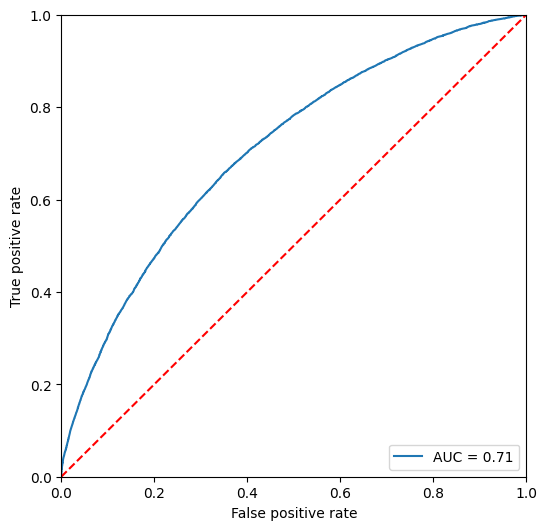

In [219]:
# get the values required to plot a ROC curve
import sklearn.metrics as metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test_proba['y_test_class_actual'], y_test_proba['y_hat_test_proba'])
roc_auc = metrics.auc(fpr, tpr)
# roc_curve n gini
Gini_index = round((2* roc_auc -1),2)
print('Hệ số gini của mô hình là {}'.format(Gini_index))

plt.figure(figsize = (6, 6))
plt.plot(fpr, tpr, label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc =  'lower right')
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()


Tính điểm Scorecard
---
$$
Credit Score = (beta \cdot WOE + \frac{alpha}{n}) \cdot Factor + \frac{Offset}{n}
$$

Note:
- $ Odds =  1:50 $
- $ Base_score = 600 $
- $ pdo \space là\space mức\space điểm\space để \space gấp \space đôi \space odds (mặc \space định = 20) $
- $ Factor = \frac{pdo}{ln(2)} $
- $ Offset = Base_score - Factor \cdot ln(Odds) $

In [264]:
def CreditScore(beta, alpha, woe, n = 12, odds = 1/4, pdo = -50, thres_score = 600):
  factor = pdo/np.log(2)
  offset = thres_score - factor*np.log(odds)
  score = (beta*woe+alpha/n)*factor+offset/n
  return score

In [222]:
logit_model = LogisticRegression(solver = 'newton-cg', max_iter=1000, fit_intercept=True, tol=0.0001, C=100, penalty='l2', random_state=1)

In [227]:
x_train_o, y_train_o = smote.fit_resample(x_train, y_train)
logit_model.fit(x_train_o, y_train_o)

LogisticRegression(C=100, max_iter=1000, random_state=1, solver='newton-cg')

In [228]:
betas_dict = dict(zip(list(x_train_o.columns), logit_model.coef_[0]))
alpha = logit_model.intercept_[0]
betas_dict

{'term': 0.5017634988377678,
 'int_rate': 0.35455587816918893,
 'grade': 0.4323538178316345,
 'home_ownership': 0.8833675194510224,
 'annual_inc': 0.9893025165275254,
 'verification_status': 0.1668271252471074,
 'purpose': 0.5472081877752546,
 'dti': 0.615866410709596,
 'total_rec_late_fee': 0.9563289296294618,
 'loan_issue_m': 0.6057313474986074}

In [233]:
woe = woe.drop(columns = 'index')

In [266]:
columns = list(woe['Variable'])
columns
beta = []
alpha = logit_model.intercept_[0]
for col in columns:
    beta.append(betas_dict[col])
    woe['beta'] = beta

ValueError: Length of values (1) does not match length of index (61)

In [268]:
score = CreditScore(beta = woe['beta'], alpha =  alpha, woe = woe['WoE'], n = 10, odds = 1/50, pdo = 20, thres_score = 600)
woe['score'] = score

In [342]:
woe.head()

,Variable,Cutoff,WoE
0,term,36,-0.243
1,term,60,0.679
2,int_rate,"(11.612, 13.676]",-0.228
3,int_rate,"(13.676, 15.74]",0.102
4,int_rate,"(15.74, 17.804]",0.398


In [339]:
# Giả sử một hồ sơ ngẫu nhiên có các thông số như sau
test_obs = df.iloc[1, :]
pd.DataFrame(test_obs).transpose()

,term,int_rate,grade,home_ownership,annual_inc,verification_status,purpose,dti,total_rec_late_fee,loan_issue_m,loan_status
1,60,"(13.676, 15.74]",C,RENT,"(1895, 30000]",Source Verified,car,"(-0.04, 3.999]","(-0.1, 35.868]","(30.0, 80.0]",1
